# ResNeXt Classification | PyTorch

In [ ]:
!pip install torchvision==0.13.0 torch==1.12.0 

Firstly, we need to analyze the dataset well. We have train and test folders. Inside them we have 4 classes so we need to prepare our model according to classes.

**Firstly, we load our libraries to start.**



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchmetrics.functional import auc
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm

import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve
warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


**We shouldn't start our proccesses without GPU support of kaggle. So after checking whether we got the GPU or not, we are ready to load our data...**

**We need a validation dataset. Because of that we need to split our folders to two. With splitfolders library, we can split folders with specified ratio. I set our values to train:0.8, val:0.2 and test:0 because we have test folder already...**

In [2]:
!pip install split-folders

import splitfolders as sf

sf.ratio('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train','output',ratio=(0.8,0.2,0),seed=42)

Copying files: 5121 files [00:41, 123.77 files/s]


**We decide out BATCH_SIZE, EPOCH and LEARNING RATE at the beginning to run code with less effort.**

**I used ImageFolder function and dictionary to load our data with batches and also used data augmentation.**

In [3]:
BATCH_SIZE=8
EPOCH=40
LEARNING_RATE=0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(200),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=4)
                                            }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


**Here we can see our image's shapes and looks. We can decide our image sizes with this function whether its good or not...**

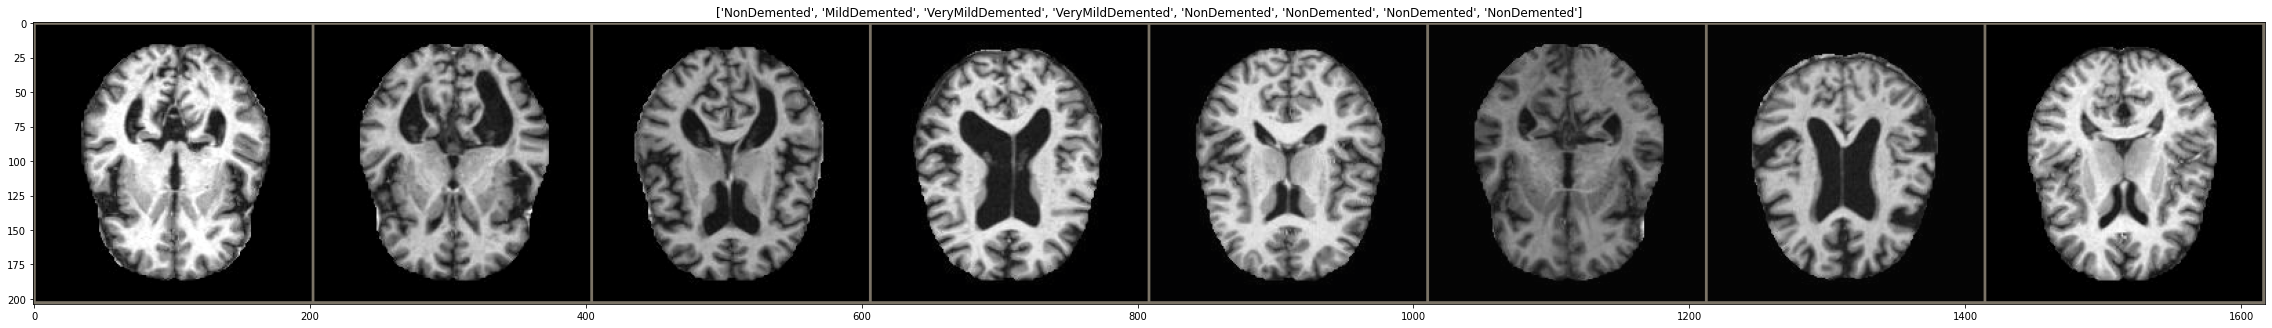

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**I am saving better models than before in order to take the best ones...**

**I am loading train and validation batches one by one and starting the training section...**

In [5]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        os.mkdir(f'./modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'./modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                train_losses = []
                valid_losses = []

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'./modelPerformance/{name}/'+sorted(os.listdir(f'./modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

**I used resnext50. You can use alternatives like I wrote down. Weights can be little bit problematic because of allennlp library...**

In [6]:
# A dictionary of models.
modeller={
    'resnext':models.resnext50_32x4d(pretrained=True)
    
}
try:
    os.mkdir(f'./modelPerformance')
except:
    print('Dosya var')
"""
'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)
'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)

'Vit_b_16': models.vit_b_16(pretrained=True),
    'Vit_b_32': models.vit_b_32(pretrained=True),
    'Vit_h_14': models.vit_h_14(),
    'Vit_l_16': models.vit_l_16(pretrained=True),
    'Vit_l_32': models.vit_l_32(pretrained=True),
'resnet18':models.resnet18(pretrained=True),
    'resnet34':models.resnet34(pretrained=True),
    
    'densenet121':models.densenet121(pretrained=True),
    'densenet169':models.densenet169(pretrained=True),

"""


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

"\n'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),\n    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)\n'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),\n    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)\n\n'Vit_b_16': models.vit_b_16(pretrained=True),\n    'Vit_b_32': models.vit_b_32(pretrained=True),\n    'Vit_h_14': models.vit_h_14(),\n    'Vit_l_16': models.vit_l_16(pretrained=True),\n    'Vit_l_32': models.vit_l_32(pretrained=True),\n'resnet18':models.resnet18(pretrained=True),\n    'resnet34':models.resnet34(pretrained=True),\n    \n    'densenet121':models.densenet121(pretrained=True),\n    'densenet169':models.densenet169(pretrained=True),\n\n"

**Here, if you want to try vgg I configured the settings according to it.**

In [7]:
for name,model in modeller.items(): 
    model_ft = model
    
    # In resnet there are different kind of settings to train
    if 'vgg' in name:
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, len(class_names)),nn.Softmax())
    else:
        num_ftrs = model_ft.fc.in_features
        model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())


    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

Epoch 1/40
----------


100%|██████████| 511/511 [04:04<00:00,  2.09it/s]


train Loss: 1.1244 Acc: 0.6056


100%|██████████| 127/127 [00:50<00:00,  2.53it/s]


val Loss: 1.0795 Acc: 0.6491

Epoch 2/40
----------


100%|██████████| 511/511 [04:00<00:00,  2.13it/s]


train Loss: 1.0557 Acc: 0.6833


100%|██████████| 127/127 [00:49<00:00,  2.58it/s]


val Loss: 1.0784 Acc: 0.6383

Epoch 3/40
----------


100%|██████████| 511/511 [03:58<00:00,  2.14it/s]


train Loss: 1.0076 Acc: 0.7297


100%|██████████| 127/127 [00:50<00:00,  2.53it/s]


val Loss: 1.1002 Acc: 0.6276

Epoch 4/40
----------


100%|██████████| 511/511 [03:59<00:00,  2.13it/s]


train Loss: 1.0053 Acc: 0.7311


 57%|█████▋    | 73/127 [00:27<00:19,  2.83it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ujk5qkik'
100%|██████████| 127/127 [00:48<00:00,  2.64it/s]


val Loss: 1.0349 Acc: 0.6911

Epoch 5/40
----------


100%|██████████| 511/511 [03:52<00:00,  2.20it/s]


train Loss: 0.9892 Acc: 0.7485


100%|██████████| 127/127 [00:46<00:00,  2.72it/s]


val Loss: 1.0298 Acc: 0.6911

Epoch 6/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9908 Acc: 0.7480


100%|██████████| 127/127 [00:46<00:00,  2.73it/s]


val Loss: 1.0537 Acc: 0.6696

Epoch 7/40
----------


 39%|███▉      | 199/511 [01:30<02:21,  2.20it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-uldtoqx8'
100%|██████████| 511/511 [03:51<00:00,  2.21it/s]


train Loss: 0.9737 Acc: 0.7634


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 1.0034 Acc: 0.7283

Epoch 8/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9512 Acc: 0.7873


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9970 Acc: 0.7292

Epoch 9/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.23it/s]


train Loss: 0.9353 Acc: 0.8027


100%|██████████| 127/127 [00:46<00:00,  2.73it/s]


val Loss: 1.0025 Acc: 0.7273

Epoch 10/40
----------


100%|██████████| 511/511 [03:48<00:00,  2.23it/s]


train Loss: 0.9162 Acc: 0.8247


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9879 Acc: 0.7439

Epoch 11/40
----------


100%|██████████| 511/511 [03:48<00:00,  2.23it/s]


train Loss: 0.9313 Acc: 0.8071


100%|██████████| 127/127 [00:47<00:00,  2.69it/s]


val Loss: 0.9724 Acc: 0.7625

Epoch 12/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.23it/s]


train Loss: 0.9159 Acc: 0.8234


100%|██████████| 127/127 [00:46<00:00,  2.74it/s]


val Loss: 0.9806 Acc: 0.7478

Epoch 13/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.23it/s]


train Loss: 0.9154 Acc: 0.8259


 66%|██████▌   | 84/127 [00:31<00:15,  2.81it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-09sv2pg4'
100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9902 Acc: 0.7351

Epoch 14/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9230 Acc: 0.8171


100%|██████████| 127/127 [00:48<00:00,  2.65it/s]


val Loss: 0.9817 Acc: 0.7537

Epoch 15/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.23it/s]


train Loss: 0.9125 Acc: 0.8274


100%|██████████| 127/127 [00:46<00:00,  2.72it/s]


val Loss: 0.9669 Acc: 0.7644

Epoch 16/40
----------


100%|██████████| 511/511 [03:51<00:00,  2.21it/s]


train Loss: 0.9126 Acc: 0.8274


 28%|██▊       | 36/127 [00:13<00:33,  2.71it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-onrcokz5'
100%|██████████| 127/127 [00:48<00:00,  2.64it/s]


val Loss: 0.9692 Acc: 0.7595

Epoch 17/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9041 Acc: 0.8371


100%|██████████| 127/127 [00:47<00:00,  2.69it/s]


val Loss: 0.9506 Acc: 0.7771

Epoch 18/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.23it/s]


train Loss: 0.9049 Acc: 0.8349


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9698 Acc: 0.7634

Epoch 19/40
----------


100%|██████████| 511/511 [03:48<00:00,  2.23it/s]


train Loss: 0.9138 Acc: 0.8259


  1%|          | 1/127 [00:00<00:43,  2.89it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-rzsz6vqx'
100%|██████████| 127/127 [00:47<00:00,  2.69it/s]


val Loss: 0.9874 Acc: 0.7468

Epoch 20/40
----------


100%|██████████| 511/511 [03:51<00:00,  2.21it/s]


train Loss: 0.9170 Acc: 0.8220


100%|██████████| 127/127 [00:47<00:00,  2.70it/s]


val Loss: 0.9528 Acc: 0.7722

Epoch 21/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.21it/s]


train Loss: 0.9179 Acc: 0.8217


100%|██████████| 127/127 [00:47<00:00,  2.66it/s]


val Loss: 0.9795 Acc: 0.7478

Epoch 22/40
----------


  4%|▍         | 21/511 [00:09<03:30,  2.32it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-wjrrvsj4'
100%|██████████| 511/511 [03:51<00:00,  2.20it/s]


train Loss: 0.9067 Acc: 0.8305


 31%|███       | 39/127 [00:14<00:30,  2.87it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-q_c07amw'
100%|██████████| 127/127 [00:46<00:00,  2.70it/s]


val Loss: 0.9449 Acc: 0.7859

Epoch 23/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9188 Acc: 0.8208


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9543 Acc: 0.7771

Epoch 24/40
----------


100%|██████████| 511/511 [03:51<00:00,  2.21it/s]


train Loss: 0.9113 Acc: 0.8269


100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9603 Acc: 0.7742

Epoch 25/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9119 Acc: 0.8283


100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9786 Acc: 0.7556

Epoch 26/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9126 Acc: 0.8264


100%|██████████| 127/127 [00:46<00:00,  2.72it/s]


val Loss: 0.9818 Acc: 0.7468

Epoch 27/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9113 Acc: 0.8291


100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9418 Acc: 0.7859

Epoch 28/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.21it/s]


train Loss: 0.9104 Acc: 0.8305


100%|██████████| 127/127 [00:47<00:00,  2.66it/s]


val Loss: 0.9607 Acc: 0.7713

Epoch 29/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.22it/s]


train Loss: 0.9079 Acc: 0.8313


100%|██████████| 127/127 [00:46<00:00,  2.70it/s]


val Loss: 0.9638 Acc: 0.7644

Epoch 30/40
----------


 95%|█████████▌| 486/511 [03:37<00:10,  2.28it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-vsy3krm9'
100%|██████████| 511/511 [03:48<00:00,  2.23it/s]


train Loss: 0.9142 Acc: 0.8266


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9520 Acc: 0.7820

Epoch 31/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.22it/s]


train Loss: 0.9128 Acc: 0.8269


100%|██████████| 127/127 [00:48<00:00,  2.64it/s]


val Loss: 0.9493 Acc: 0.7879

Epoch 32/40
----------


100%|██████████| 511/511 [03:52<00:00,  2.19it/s]


train Loss: 0.9084 Acc: 0.8310


100%|██████████| 127/127 [00:47<00:00,  2.69it/s]


val Loss: 0.9707 Acc: 0.7566

Epoch 33/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.22it/s]


train Loss: 0.9125 Acc: 0.8278


100%|██████████| 127/127 [00:46<00:00,  2.72it/s]


val Loss: 0.9639 Acc: 0.7674

Epoch 34/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.22it/s]


train Loss: 0.9085 Acc: 0.8305


  6%|▋         | 8/127 [00:03<00:43,  2.72it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jbfkq9px'
100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9634 Acc: 0.7615

Epoch 35/40
----------


100%|██████████| 511/511 [03:49<00:00,  2.22it/s]


train Loss: 0.9132 Acc: 0.8259


100%|██████████| 127/127 [00:48<00:00,  2.64it/s]


val Loss: 0.9536 Acc: 0.7732

Epoch 36/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.21it/s]


train Loss: 0.9092 Acc: 0.8291


 91%|█████████▏| 116/127 [00:43<00:03,  2.88it/s]Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-48kbh8ad'
100%|██████████| 127/127 [00:46<00:00,  2.70it/s]


val Loss: 0.9479 Acc: 0.7859

Epoch 37/40
----------


100%|██████████| 511/511 [03:51<00:00,  2.21it/s]


train Loss: 0.9077 Acc: 0.8330


100%|██████████| 127/127 [00:46<00:00,  2.71it/s]


val Loss: 0.9617 Acc: 0.7752

Epoch 38/40
----------


100%|██████████| 511/511 [03:53<00:00,  2.19it/s]


train Loss: 0.9020 Acc: 0.8379


100%|██████████| 127/127 [00:47<00:00,  2.67it/s]


val Loss: 0.9401 Acc: 0.7937

Epoch 39/40
----------


100%|██████████| 511/511 [03:50<00:00,  2.21it/s]


train Loss: 0.9191 Acc: 0.8200


100%|██████████| 127/127 [00:47<00:00,  2.66it/s]


val Loss: 0.9593 Acc: 0.7742

Epoch 40/40
----------


100%|██████████| 511/511 [03:52<00:00,  2.20it/s]


train Loss: 0.9091 Acc: 0.8295


100%|██████████| 127/127 [00:49<00:00,  2.58it/s]


val Loss: 0.9759 Acc: 0.7537

Training complete in 186m 2s
Best val Acc: 0.793744


In [9]:
'./modelPerformance/resnext/'+sorted(os.listdir('./modelPerformance/resnext'))[-1]

'./modelPerformance/resnext/best_model_0.7937acc_40epochs.h5'

In [10]:
best_model=torch.load('./modelPerformance/resnext/'+sorted(os.listdir('./modelPerformance/resnext'))[-1])

In [18]:
os.listdir('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')

['test', 'train']

In [29]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [31]:
data_dir = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['test']}
dataloaders = {
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=0)
                                            }

def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

test_model(best_model,'cuda',dataloaders['test'])

Correct Prediction: 843  Total Images: 1279
Test Accuracy = 0.659109
